In [1]:
import os 
import numpy as np 
import pandas as pd 
import scanpy as sc
import anndata
import copy
import desc
import matplotlib.pyplot as plt
import seaborn as sns 
import utils.color_utils as color_utils

# following line ensures the pl plots inline 
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go

from sklearn.metrics import mean_squared_error
from scipy import stats

In [10]:
adata = desc.read_h5ad('../files/Tsukahara/GSE173947_home_cage_matureOSN.h5ad')

In [11]:
# Generate meta file of top expressing Olfrs from each cell and add that into adata.obs
meta_mOSN = pd.read_csv('../files/Tsukahara/GSE173947_home_cage_metadata.csv')[['Unnamed: 0','top_Olfr']]
meta_mOSN.rename(columns={'Unnamed: 0':'index'}, inplace=True)
meta_mOSN = meta_mOSN.set_index('index')
adata.obs = adata.obs.join(meta_mOSN)

In [ ]:
# Quickly evaluate the expression of olfr in mOSNs
print(f'Olfr78 expressed in {len(meta_mOSN[meta_mOSN.top_Olfr == "Olfr78"]) / len(meta_mOSN)}% of mOSN \nOlfr78: {len(meta_mOSN[meta_mOSN.top_Olfr == "Olfr78"])} \nTotal mOSNs: {len(meta_mOSN)}')

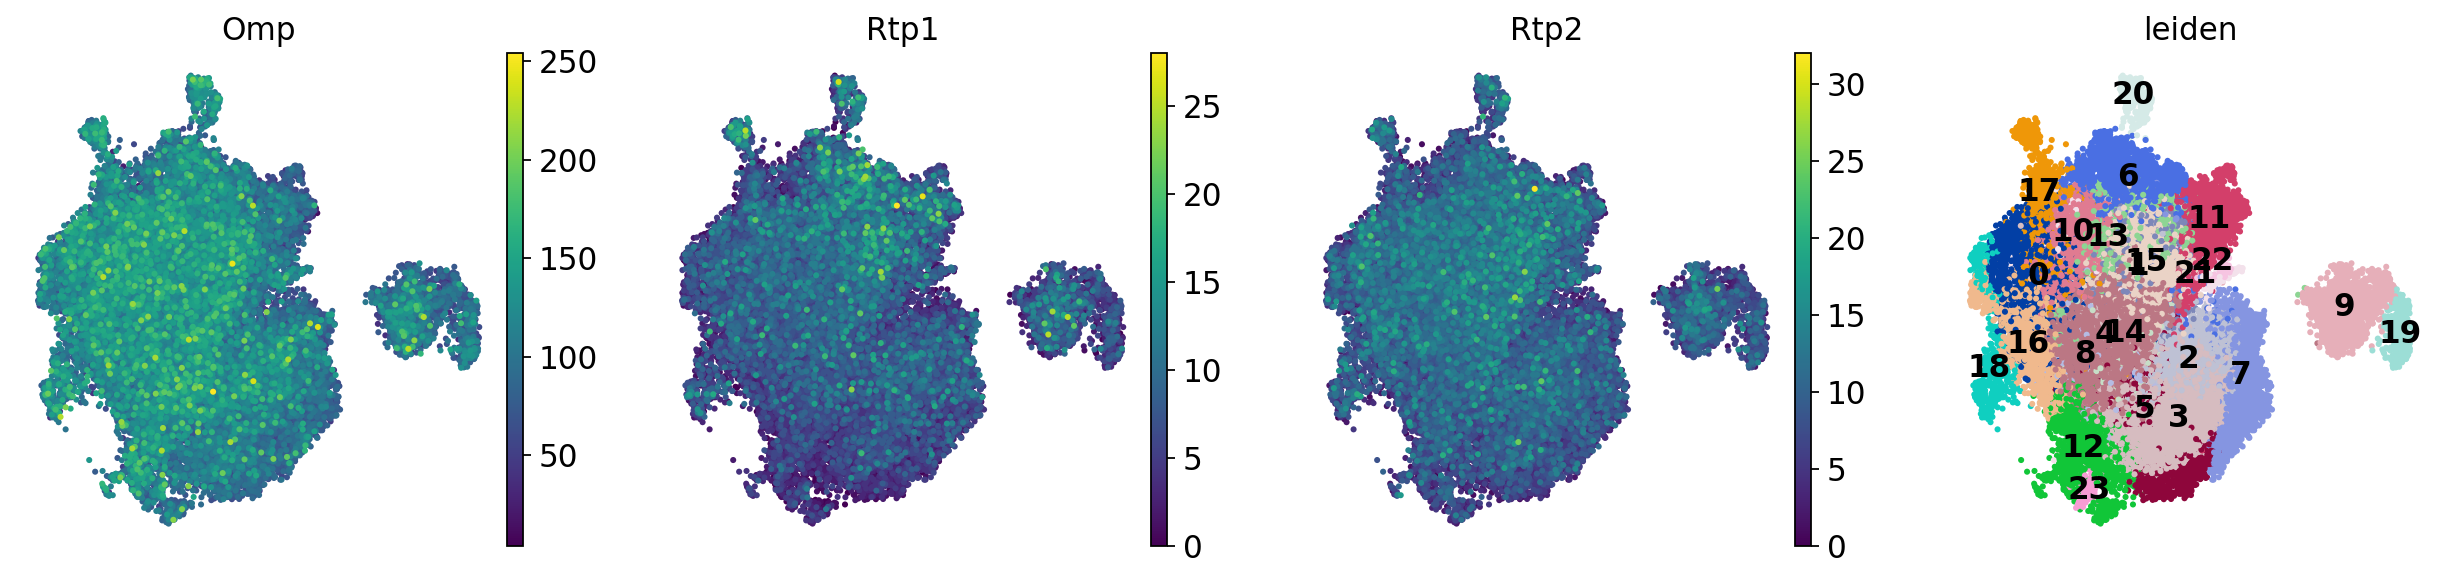

In [9]:
sc.set_figure_params(facecolor='white', color_map = 'viridis')
sc.pl.umap(adata, color=['Omp','Rtp1','Rtp2', 'leiden'], 
           legend_loc='on data', size=30, 
           frameon=False)

#### OR dependency analysis

Label single cell data with uOR and oOR information 

In [12]:
# Read in PNAS2017 Ruhcira Shamra identified uOR and oOR labeled Olfrs 
pnas_OR = pd.read_csv('../output/Facs_screening_PNAS2020.csv')
# bin into uOR and oOR_null 
uOR = pnas_OR[(pnas_OR['oOR/uOR'] == 'uOR')]['Olfr'].tolist()
oOR = pnas_OR[(pnas_OR['oOR/uOR'] == 'oOR')]['Olfr'].tolist()
oOR_null = pnas_OR[(pd.isnull(pnas_OR['independent/dependent'])) &
                  (pnas_OR['oOR/uOR'] == 'oOR')]['Olfr'].tolist()
Rtp_dependent =  pnas_OR[(pnas_OR['independent/dependent'] == 'RTP-dependent')]['Olfr'].tolist()
Rtp_independent =  pnas_OR[(pnas_OR['independent/dependent'] == 'RTP-independent')]['Olfr'].tolist()

In [13]:
adata.obs['OR_type'] = 'undefined'
adata.obs.loc[adata.obs.top_Olfr.isin(uOR), ['OR_type']] = 'uOR'
adata.obs.loc[adata.obs.top_Olfr.isin(oOR), ['OR_type']] = 'oOR'
adata.obs['OR_dependency'] = 'undefined'
adata.obs.loc[adata.obs.top_Olfr.isin(Rtp_independent), ['OR_dependency']] = 'RTP-independent'
adata.obs.loc[adata.obs.top_Olfr.isin(Rtp_dependent), ['OR_dependency']] = 'RTP-dependent'
# Assign columns to category type 
adata.obs['OR_type'] = adata.obs['OR_type'].astype('category')
adata.obs['OR_dependency'] = adata.obs['OR_dependency'].astype('category')
adata.obs['OR_dependency'].cat.reorder_categories(['RTP-independent', 
                                                   'RTP-dependent','undefined'], inplace=True)
adata.write(results_file)

/tmp/ipykernel_622381/223313448.py:10: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata.obs['OR_dependency'].cat.reorder_categories(['RTP-independent',
/data/jlu/anaconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'top_Olfr' as categorical


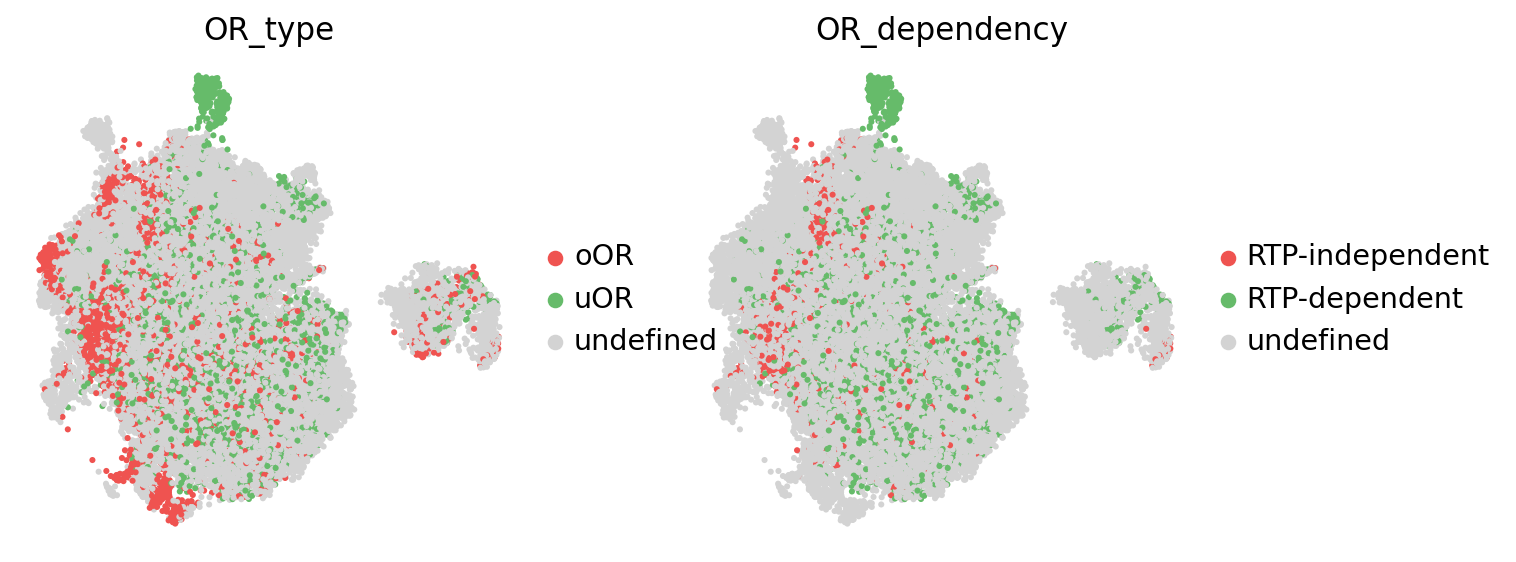

In [14]:
sc.set_figure_params(facecolor='white', color_map = 'viridis')

sc.pl.umap(adata, color=['OR_type', 'OR_dependency'], 
           size=30, sort_order=False, 
           frameon=False, 
           palette=['#EF5350','#66BB6A','#D3D3D3'])

Initially Rtp_dependent and uOR includes a distinct cluster on the top island. Would be interesting to see what Olfr makes up of that cluster. 

In [2]:
results_file = "../files/Tsukahara/GSE173947_home_cage_matureOSN.h5ad"
adata = sc.read(results_file)

In [ ]:
adata.obs[adata.obs.leiden == '20'].top_Olfr.unique().to_list()
sc.pl.umap(adata, color=adata.obs[adata.obs.leiden == '20'].top_Olfr.unique().to_list()
, size=30)

In [16]:
# Find the interested genes in contained in adata. 
# Additionally spits out the order in which the genes are stored in matrix 
interested_genes = ['Omp','Rtp1', 'Rtp2', 'Gfy', 'Clgn', 'Syt1', 'Syt5']
interested_genes = list(adata.raw.var_names[adata.raw.var_names.isin(interested_genes)])
count_df = pd.DataFrame(adata.raw.X[:, adata.raw.var_names.isin(interested_genes)], 
            columns=[i+"_counts" for i in interested_genes])
count_df.insert(0, 'OR_dependency', adata.obs['OR_dependency'].values)
count_df.insert(0, 'OR_type', adata.obs['OR_type'].values)
count_df.insert(0, 'Olfr', adata.obs['top_Olfr'].values)

# Save Rhbdf2 expression file 
# count_df.to_csv('./output/tsukahara/Chaperone_counts.csv')
count_df = pd.read_csv('../output/tsukahara/count_csv/Chaperone_counts.csv', index_col=0)

In [29]:
# Log transform counts

log1p_df = pd.DataFrame(count_df[['Olfr', 'OR_type', 'OR_dependency']])

for i in list(count_df.columns[count_df.columns.str.contains('_counts')]):
    log1p_df[i.split('_')[0]+'_log1p'] = np.log1p(count_df[i])

# Change column types to category for plotting 
log1p_df['Olfr'] = log1p_df['Olfr'].astype('category')
log1p_df['OR_type'] = log1p_df['OR_type'].astype('category')
log1p_df['OR_dependency'] = log1p_df['OR_dependency'].astype('category')

# Save count_df 
# log1p_df.to_csv('./output/tsukahara/count_csv/Chaperone_log1p.csv')

In [ ]:
# Quick plot to see how the other interested genes correslate with Rhbdf2
y_column = list(log1p_df.columns[log1p_df.columns.str.contains('_log1p')])
plot_df = pd.melt(log1p_df, id_vars=['Olfr', 'OR_type', 'OR_dependency'], value_vars=y_column)

fig = px.box(plot_df, 
             x = 'variable', 
             y = 'value', 
             color = 'OR_type',
             notched = True,
#              facet_col='variable',
             title = "",
             category_orders={"OR_type": ['uOR','oOR','undefined'],
                              "OR_dependency": ['RTP-dependent','RTP-independent','undefined']}
            )
fig.update_xaxes(type='category')

fig.update_layout(
        margin=dict(
            l=50, r=50, b=100, t=100,pad=10
        ),
        template='plotly_white'
    )
fig.show()
# fig.write_html('./output/tsukahara/plots/ChaperonesExpression_box_ORtype.html')

##### Rank gene group analysis 

In [ ]:
sc.set_figure_params(facecolor='white', color_map = 'viridis')
sc.tl.rank_genes_groups(adata, 'OR_type', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names', 'pvals']}).to_csv('./output/tsukahara/count_csv//DE_byORtype.csv')

In [ ]:
sc.set_figure_params(facecolor='white', color_map = 'viridis')
sc.tl.rank_genes_groups(adata, 'OR_dependency', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names', 'pvals']}).to_csv('./output/tsukahara/count_csv/DE_byORdependency.csv')

#### Syt1 Olfr analysis

In [3]:
results_file = "../files/Tsukahara/GSE173947_home_cage_matureOSN.h5ad"
adata = sc.read(results_file)

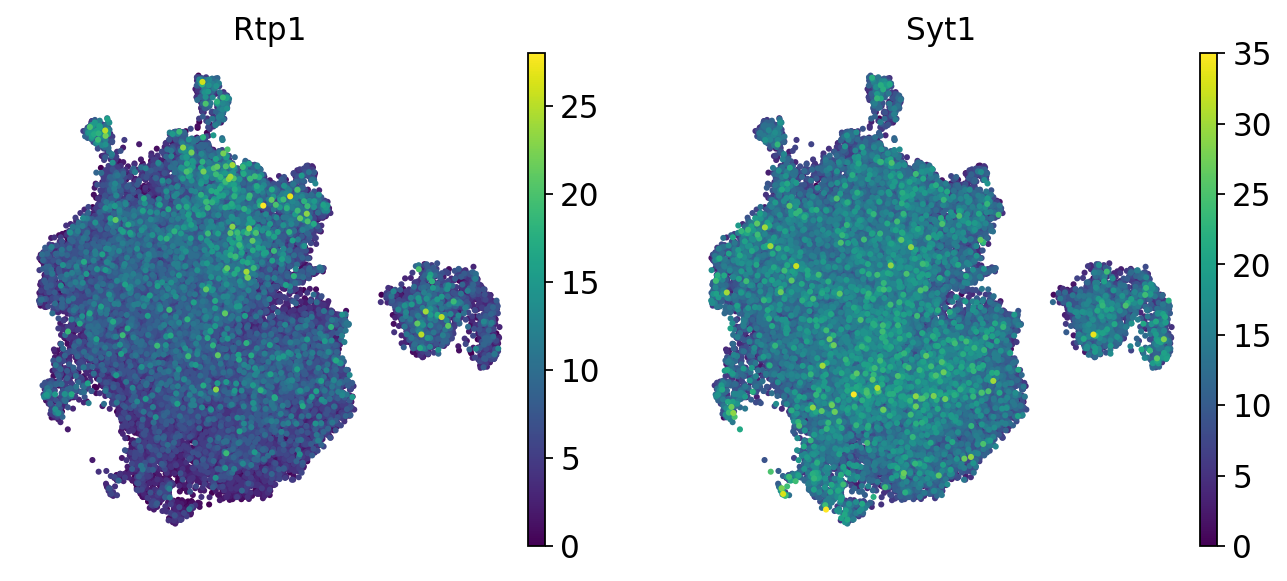

In [55]:
sc.set_figure_params(facecolor='white', color_map = 'viridis')
sc.pl.umap(adata, color=['Rtp1', 'Syt1'], 
           legend_loc='on data', size=30, 
           frameon=False)

In [6]:
count_df = pd.read_csv('../output/tsukahara/count_csv/Chaperone_counts.csv', index_col=0)

Syt1_df = count_df.groupby(['Olfr'], as_index=False).agg({'Syt1_counts':['mean', 'sum', 'std', 'count'], 
                                                        'Rtp1_counts':['mean', 'sum', 'std']}).reset_index(drop=True)
# Renaming columns
Syt1_df.columns = ['_'.join([i[0].split('_')[0], i[1]]) if '_' in i[0] else ''.join(i) for i in Syt1_df.columns]
Syt1_df.columns = ['num_cells' if 'count' in i else i for i in Syt1_df.columns] # Rename the 'counts' column to number of cells
# Merge in OR Rtp1 dependencies 
Syt1_df = pd.merge(Syt1_df, count_df[['Olfr', 'OR_type', 'OR_dependency']], on='Olfr', how = 'left').drop_duplicates().reset_index(drop = True)

# Get box information to merge 
or_library = pd.read_excel('../files/Matsunami/2018Jun21_Mouse_Olfr.Library_Makayla_and_Eric xlsx.xlsx')[['OLFR', 'Box', 'Well']]
or_library = or_library[~(or_library.OLFR.isna())]
or_library.columns = ['Olfr', 'Box', 'Well']

Syt1_df = pd.merge(Syt1_df, or_library, on='Olfr', how = 'left')

# Syt1_df.to_csv('../output/tsukahara/Syt1_analysis/Syt1_df.csv')

/data/jlu/anaconda3/envs/scanpy/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [3]:
Syt1_df = pd.read_csv('../output/tsukahara/Syt1_analysis/Syt1_df.csv', index_col=0)

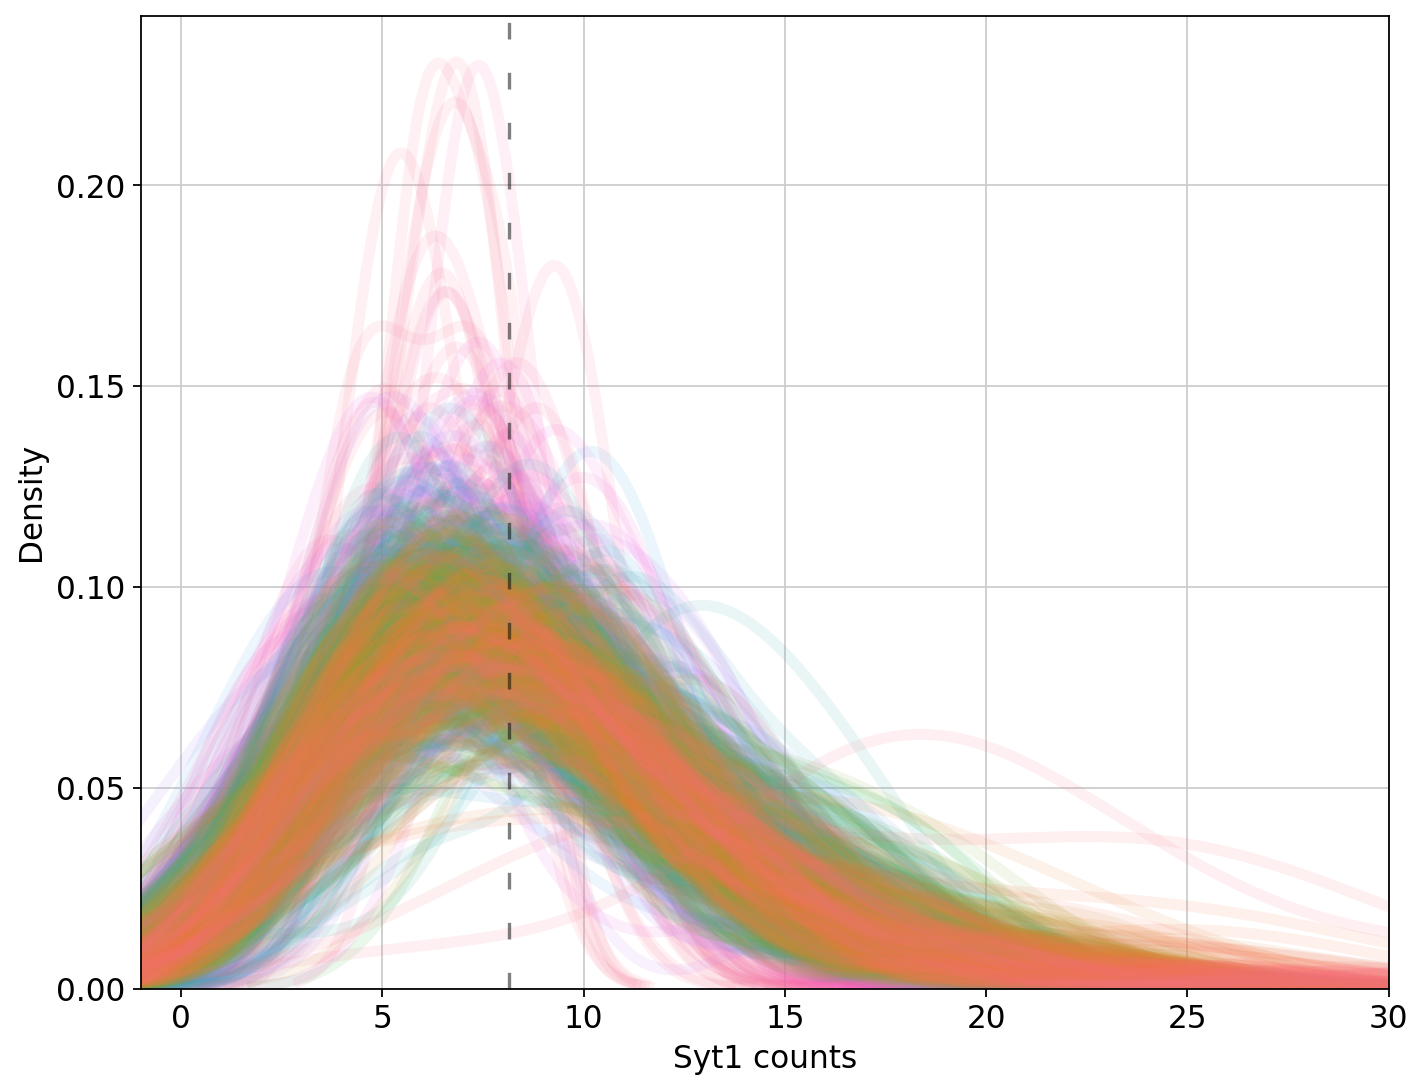

In [270]:
# Kdeplot of Syt1 expression

subset = count_df.sort_values('Syt1_counts', ascending = False)
subset = subset[subset['Olfr'].isin(Syt1_df[Syt1_df.num_cells > 5].Olfr)]

plot_df = subset.copy()
# plot_df = count_df.copy()

plt.figure(figsize=(10,8))
# Group the data by 'group' and create histograms
sns.kdeplot(data=plot_df, 
            x='Syt1_counts', 
            hue='Olfr', 
            common_norm=False, 
            fill=False, 
            alpha=0.1, linewidth=5, 
            legend=False
)
# Add mean line of Syt1 mean 
plt.axvline(x = subset['Syt1_counts'].mean(),
            color='black', alpha = 0.5,
            linestyle='--', dashes=(5,10)
            )

plt.xlabel('Syt1 counts')
plt.ylabel('Density')
plt.title('')
plt.xlim(-1, 30)
# plt.axis('off')
# plt.savefig('../output/tsukahara/Syt1_analysis/Syt1_density.png', dpi=300) 
plt.show()  

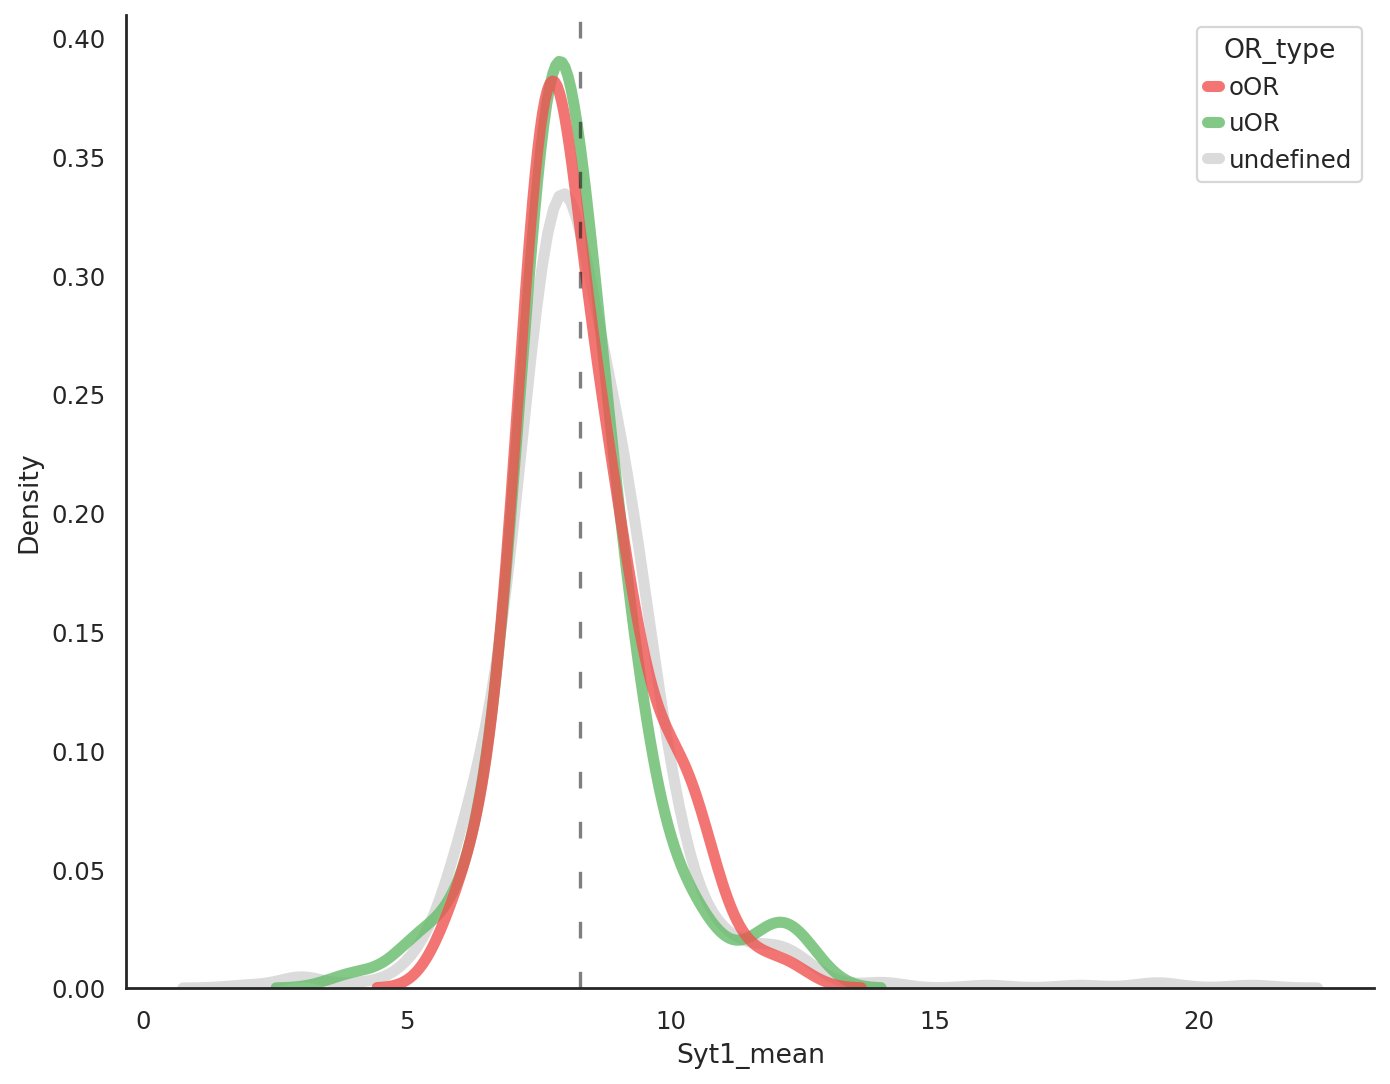

In [144]:
# Kdeplot of Syt1 expression

plot_df = Syt1_df.sort_values('OR_type').copy()
# plot_df = count_df.copy()

plt.figure(figsize=(10,8))
# Group the data by 'group' and create histograms
sns.kdeplot(data=plot_df, 
            x='Syt1_mean', 
            hue='OR_type', 
            common_norm=False, 
            fill=False, 
            alpha=0.8, linewidth=5, 
            legend='best',
            palette=['#EF5350','#66BB6A','#D3D3D3']
)
plt.axvline(x = plot_df['Syt1_mean'].mean(),
            color='black', alpha = 0.5,
            linestyle='--', dashes=(5,10)
            )

sns.set_style('white')
sns.despine()
# plt.savefig('../output/tsukahara/Syt1_analysis/Syt1_density.png', dpi=300) 
plt.show()  

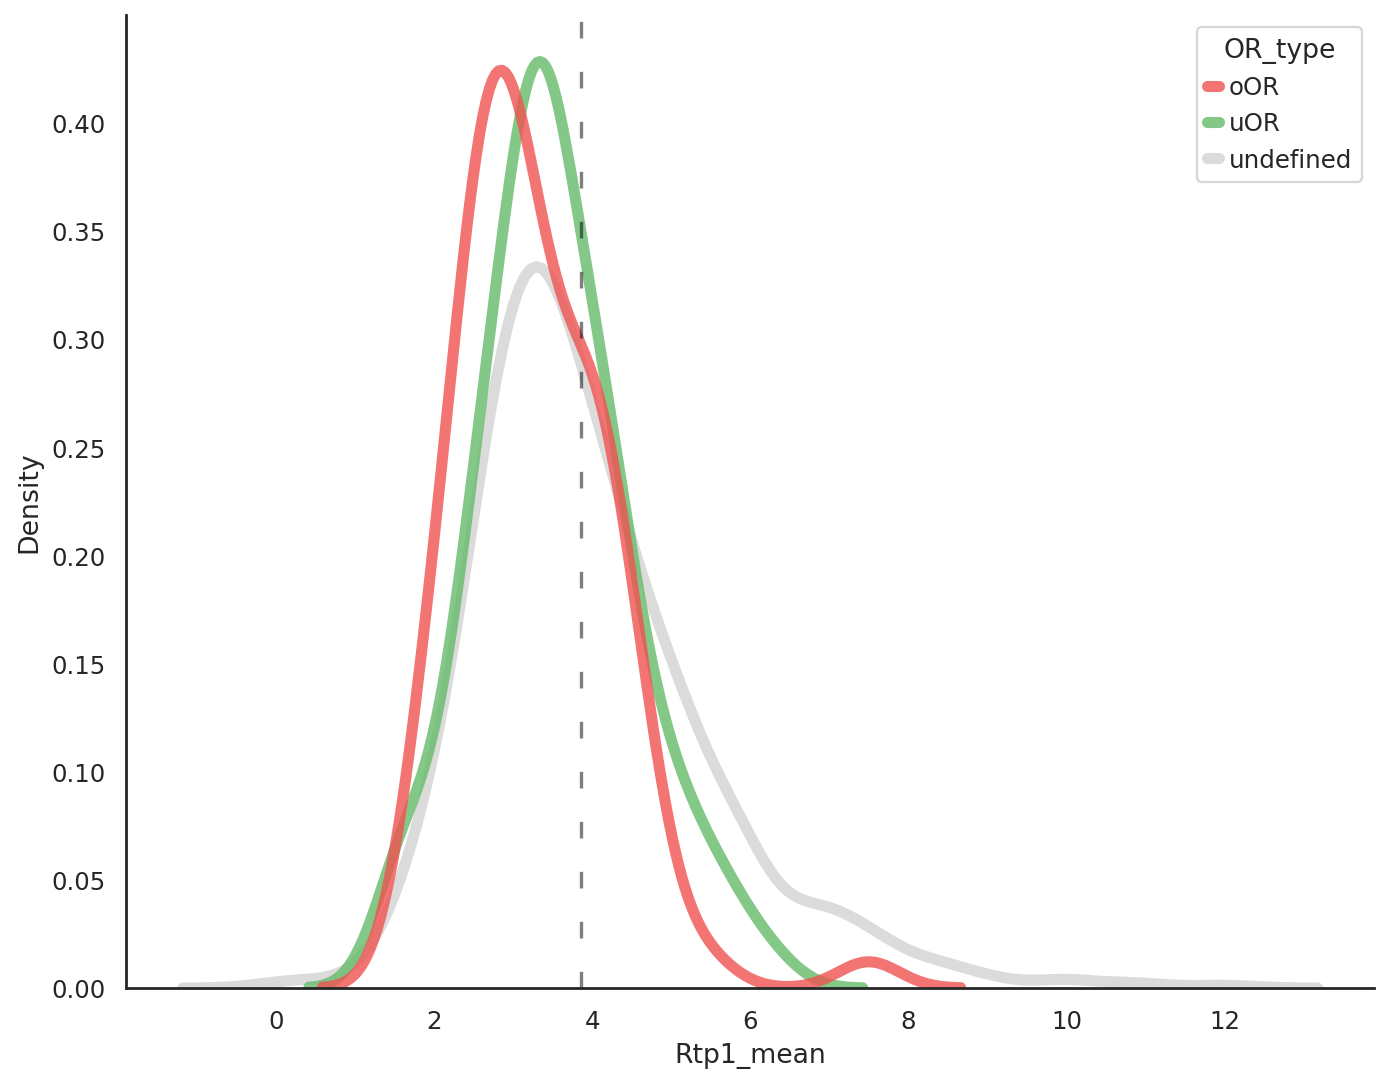

In [143]:
# Kdeplot of Syt1 expression

plot_df = Syt1_df.sort_values('OR_type').copy()
# plot_df = count_df.copy()

plt.figure(figsize=(10,8))
# Group the data by 'group' and create histograms
sns.kdeplot(data=plot_df, 
            x='Rtp1_mean', 
            hue='OR_type', 
            common_norm=False, 
            fill=False, 
            alpha=0.8, linewidth=5, 
            legend='best',
            palette=['#EF5350','#66BB6A','#D3D3D3']
)
plt.axvline(x = plot_df['Rtp1_mean'].mean(),
            color='black', alpha = 0.5,
            linestyle='--', dashes=(5,10)
            )


sns.set_style('white')
sns.despine()
# plt.savefig('../output/tsukahara/Syt1_analysis/Rtp1_density.png', dpi=300) 
plt.show()  

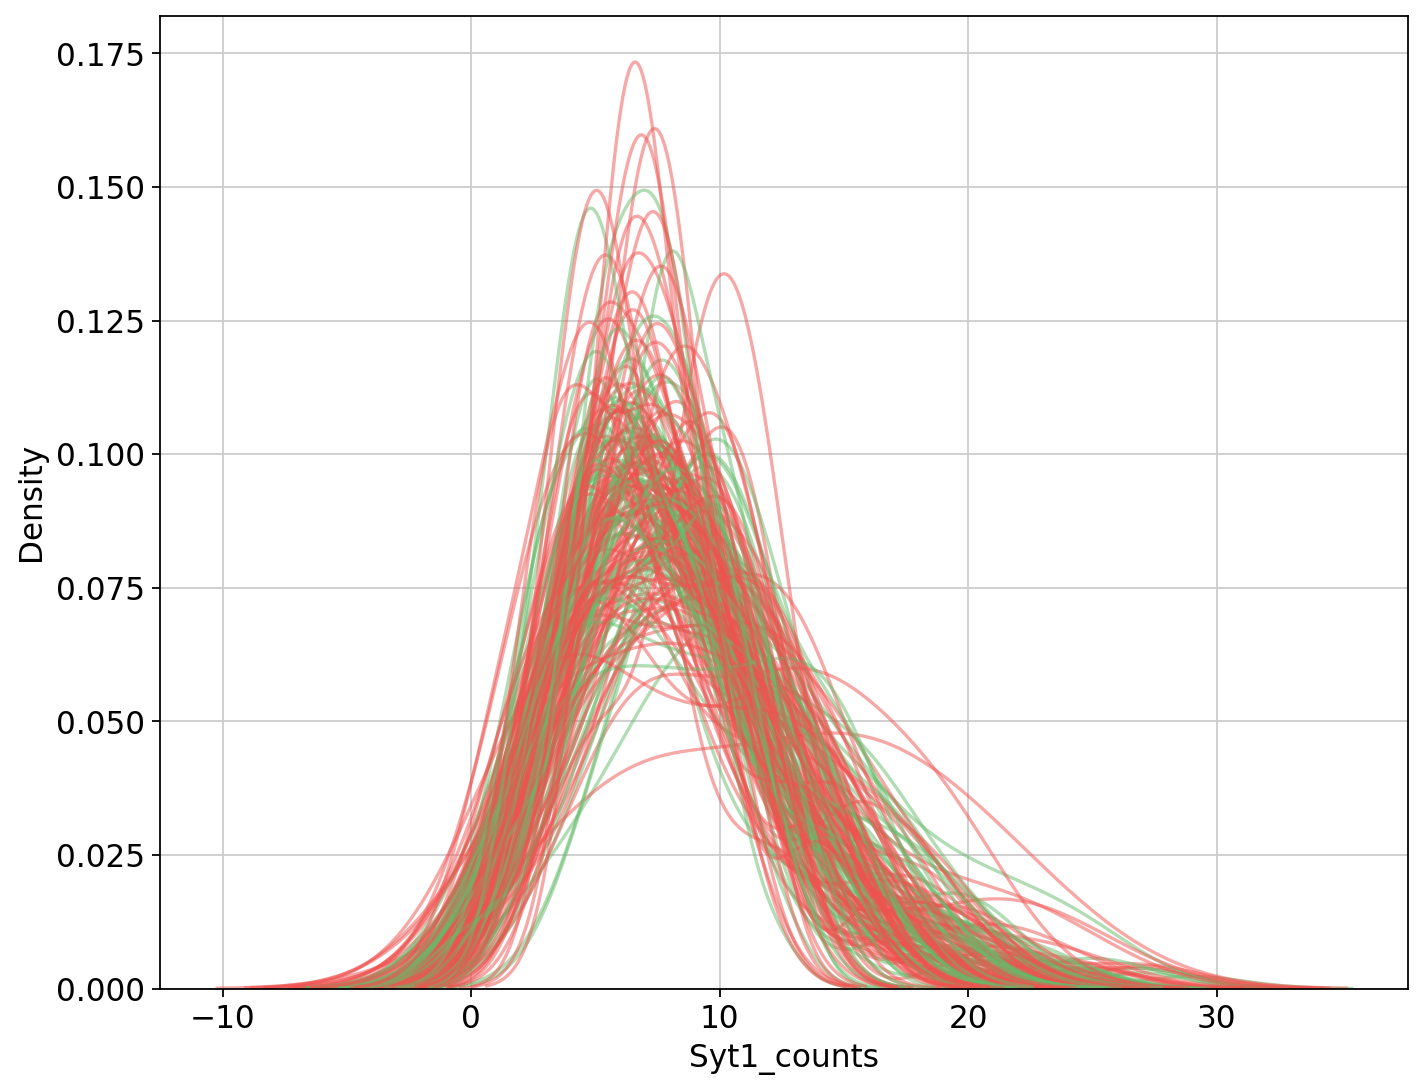

In [116]:
# Kdeplot 

gene = 'Syt1_counts'

subset = count_df.sort_values(gene, ascending = False)
subset = subset[subset['Olfr'].isin(Syt1_df[Syt1_df.num_cells > 5].Olfr)]
subset = subset[subset['OR_type'].isin(['oOR', 'uOR'])]
# subset = subset[['Olfr', 'OR_type', 'Rtp1_counts']].sort_values('Olfr')

plot_df = subset.copy()
# plot_df = count_df.copy()

plt.figure(figsize=(10,8))

for olfr in plot_df.Olfr.unique():
    if plot_df[plot_df['Olfr'] == olfr].OR_type.unique()[0] == 'uOR':
        color = '#EF5350'
    else: 
        color = '#66BB6A'
    sns.kdeplot(data=plot_df[plot_df['Olfr'] == olfr], 
                x=gene, 
                color=color,
                alpha = 0.5)
    
plt.ylabel('Density')
plt.title('')
# plt.xlim(-1, 30)
# plt.axis('off')
# plt.savefig('../output/tsukahara/Syt1_analysis/Syt1_density.png', dpi=300) 
plt.show()  

In [16]:

subset = Syt1_df[Syt1_df.num_cells > 5].copy()

fig = px.scatter(subset,
                x="Syt1_sum", 
                y="Rtp1_sum", 
                hover_data= ["Olfr"]
                )

fig.update_layout(
    title='Syt1 and Rtp1 counts correlation',
    xaxis_title='Syt1 sum per Olfr',
    yaxis_title='Rtp1 sum per Olfr',
    template='simple_white',
    margin=dict(l=50,r=50,b=100,t=100,pad=10),
    font=dict(
        size=10,  # Set the font size here
    )
)
fig.show()
# fig.write_html('../output/tsukahara/Syt1_analysis/Syt1_Rtp1_scatter_sum.html')

In [11]:

subset = Syt1_df[Syt1_df.num_cells > 5].copy()

fig = px.scatter(subset,
                x="Syt1_mean", 
                y="Rtp1_mean", 
                hover_data= ["Olfr"]
                )

fig.update_layout(
    title='Syt1 and Rtp1 counts correlation',
    xaxis_title='Syt1 mean per Olfr',
    yaxis_title='Rtp1 mean per Olfr',
    template='simple_white',
    margin=dict(l=50,r=50,b=100,t=100,pad=10),
    font=dict(
        size=10,  # Set the font size here
    )
)
fig.show()
# fig.write_html('../output/tsukahara/Syt1_analysis/Syt1_Rtp1_scatter_mean.html')

In [ ]:
import plotly.graph_objects as go

subset = count_df.sort_values('Syt1_counts', ascending = False)
olfr_counts = count_df['Olfr'].value_counts()
subset = subset[subset['Olfr'].isin(olfr_counts[olfr_counts > 5].index)]
olfr_order = Syt1_df[Syt1_df.Olfr.isin(subset.Olfr)].sort_values('mean', ascending = False).Olfr

fig = go.Figure()
for olfr in olfr_order:
    box = subset[subset.Olfr == olfr]
    fig.add_trace(go.Box(x=box["Olfr"], 
                         y=box["Syt1_counts"], 
                         name=olfr,
                         boxmean = True, 
                         showlegend = False,
                         marker_color = 'royalblue'
                )
    )
fig.show()

In [ ]:
import plotly.figure_factory as ff

subset = count_df.sort_values('Syt1_counts', ascending = False)
olfr_counts = count_df['Olfr'].value_counts()
subset = subset[subset['Olfr'].isin(olfr_counts[olfr_counts > 5].index)]
olfr_order = Syt1_df[Syt1_df.Olfr.isin(subset.Olfr)].sort_values('Syt1_mean', ascending = False).Olfr.values

hist_data = []
for olfr in olfr_order: 
    hist_data.append(subset[subset.Olfr == olfr].Syt1_counts.astype(int))
    
fig = ff.create_distplot(hist_data, 
                         olfr_order,
                         bin_size=.2, 
                         show_hist=False)
fig.show()

#### Rtp1 correlation analysis 

In [2]:
results_file = "../files/Tsukahara/GSE173947_home_cage_matureOSN.h5ad"
adata = sc.read(results_file)

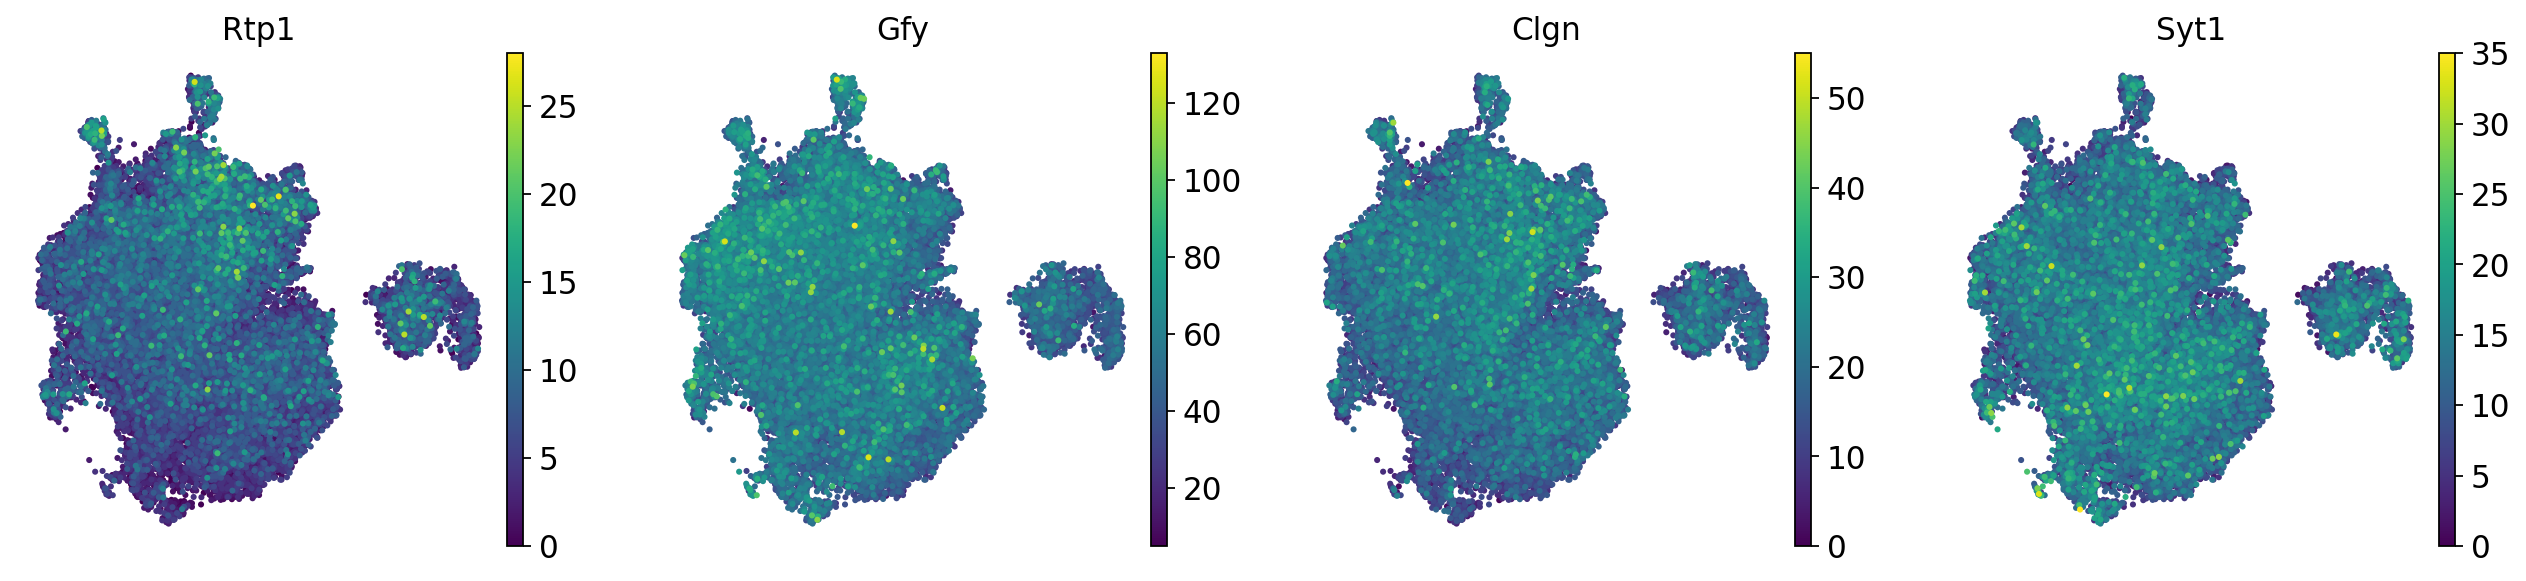

In [7]:
sc.set_figure_params(facecolor='white', color_map = 'viridis')
sc.pl.umap(adata, color=['Rtp1', 'Gfy', 'Clgn','Syt1'], 
           legend_loc='on data', size=30, 
           frameon=False)

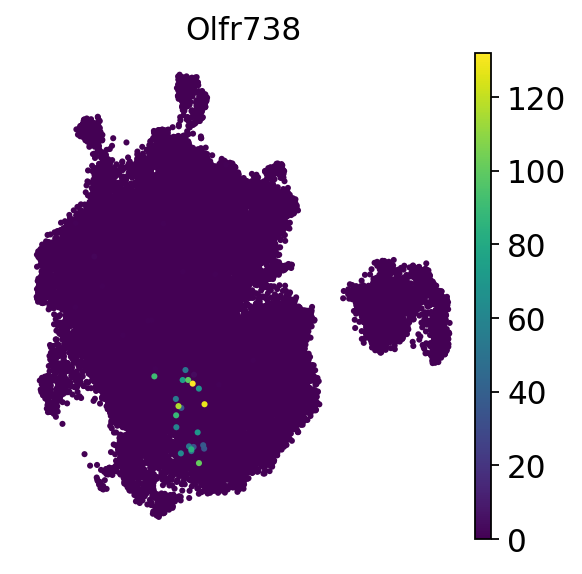

In [226]:
sc.set_figure_params(facecolor='white', color_map = 'viridis')
sc.pl.umap(adata, color=['Olfr738'], 
           legend_loc='on data', size=30, 
           frameon=False)

In [3]:
# Read in OR_rtp data. Table is curated from google doc oOR_screen
OR_df = pd.read_csv('../output/OR_rtp_from_gdoc.csv', index_col=0)
OR_df = OR_df.iloc[:,:-1] #Remove the last OR_type information 
OR_df['OR_Rtp_fc'] = OR_df['OR_Rtp1s'] / OR_df['OR']
OR_df['OR_Rtp_diff'] = OR_df['OR_Rtp1s'] - OR_df['OR']
OR_df['OR_Syt1_fc'] = OR_df['OR_Rtp1s_Syt1'] / OR_df['OR_Rtp1s']
OR_df['OR_Syt1_diff'] = OR_df['OR_Rtp1s_Syt1'] - OR_df['OR_Rtp1s']

# Generated above, also contains Rtp1 counts information 
Syt1_df = pd.read_csv('../output/tsukahara/Syt1_analysis/Syt1_df.csv', index_col=0)

# Combine 
OR_df = pd.merge(OR_df, Syt1_df, on='Olfr', how='left', suffixes=('', '_remove'))
# # remove the duplicate columns
OR_df.drop([i for i in OR_df.columns if 'remove' in i], axis=1, inplace=True)

In [5]:
fig = px.scatter(OR_df, 
                x = 'OR_Syt1_diff', 
                y = 'OR_Rtp_diff', 
                color = 'Olfr')
fig.update_traces(marker=dict(size = 10))
fig.update_layout(template='simple_white')
fig.show()
fig.write_html('../output/tsukahara/Syt1_analysis/scatter/Rtp_Syt1_diff_correlation.html')

In [327]:
fig = px.scatter(OR_df, 
                x = 'OR_Syt1_fc', 
                y = 'OR_Rtp_fc', 
                color = 'Olfr')
fig.update_traces(marker=dict(size = 10))
fig.update_layout(template='simple_white')
fig.show()
# fig.write_html('../output/tsukahara/Syt1_analysis/scatter/Rtp_Syt1_fc_correlation.html')

In [329]:
category_to_plot = ['OR_Rtp_fc', 'OR_Rtp_diff', 'OR_Syt1_fc', 'OR_Syt1_diff']
against_x = ['Syt1_mean', 'Syt1_sum', 'Rtp1_mean', 'Rtp1_sum']
for c in category_to_plot: 
    for _x in against_x: 
        fig = px.scatter(OR_df, 
                        x = _x, 
                        y = c, 
                        color = 'Olfr')
        fig.update_traces(marker=dict(size = 10))
        fig.update_layout(template='simple_white')
        # fig.show()
        fig.write_html(f'../output/tsukahara/Syt1_analysis/scatter/{c}_by_{_x}.html')

In [174]:
# Construct umap dataframe
umap_df = pd.DataFrame(adata.obsm['X_umap'], columns=['umap_x', 'umap_y'])
# Transfer cell information onto umap_df 
umap_df.insert(0, 'top_Olfr', adata.obs['top_Olfr'].reset_index(drop=True))
umap_df = pd.merge(umap_df, Syt1_df.drop(['Box', 'Well'], axis=1), how='left', left_on='top_Olfr', right_on='Olfr').drop('Olfr', axis=1)

# Add in experimental FACS geo mean values 
temp_OR_df = OR_df.iloc[:,:9]
temp_OR_df = temp_OR_df.sort_values('OR_Rtp_fc', ascending=False).groupby('Olfr').first().reset_index()
umap_df = pd.merge(umap_df, temp_OR_df, how='left', left_on='top_Olfr', right_on='Olfr').drop('Olfr', axis=1)



In [308]:
# Visualize values on umap. 
category_to_plot = ['OR_Rtp_fc', 'OR_Rtp_diff', 'OR_Syt1_fc', 'OR_Syt1_diff',  'OR', 'OR_Rtp1s', 'OR_Rtp1s_Syt1', 'num_cells']
color_cutoff = 0.05 # Top and bottom x percent 

for c in category_to_plot:
    # Plot grey background for the base of the umap 
    background_df = umap_df.sample(frac=0.2)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x = background_df['umap_x'], 
                            y = background_df['umap_y'], 
                            mode='markers',
                            marker=dict(size=10, 
                                        # color='#EEEEEE'
                                        color='#000000')))

    # Add in data points 
    subset = umap_df[~umap_df[c].isna()].sort_values(c)
    # subset = subset[subset.top_Olfr != 'Olfr1019']
    if 'diff' in c: 
        plot_color = 'balance'
        color_center = 0
        # color_max = subset[c].sort_values().iloc[int(len(subset)*(1-color_cutoff))-1]
        # color_min = subset[c].sort_values().iloc[int(len(subset)*(color_cutoff))-1]
        color_min, color_max = 0,0
    elif 'fc' in c: 
        plot_color = 'balance'
        color_center = 1
        # color_max = subset[c].sort_values().iloc[int(len(subset)*(1-color_cutoff))-1]
        # color_min = subset[c].sort_values().iloc[int(len(subset)*(color_cutoff))-1]
        color_min, color_max = 0,0
    else: 
        color_center = None 
        color_max = subset[c].sort_values().iloc[int(len(subset)*(1-color_cutoff))-1]
        color_min = subset[c].sort_values().iloc[int(len(subset)*(color_cutoff))-1]
        plot_color = 'Viridis'
    fig.add_trace(go.Scatter(x = subset['umap_x'], 
                            y = subset['umap_y'],
                            mode='markers',
                            # text=subset['top_Olfr'],
                            text = [f'{row["top_Olfr"]}<br>{c}: {round(row[c], 3)}' for _, row in subset.iterrows()],
                            hovertemplate = "%{text}",
                            marker=dict(size=10, 
                                        color=subset[c],
                                        colorbar=dict(title=c), 
                                        colorscale=plot_color,
                                        cmid=color_center,
                                        cmax=color_max,
                                        cmin=color_min
                                        )))
    fig.update_layout(title=c,
                      showlegend=False, 
                      template='simple_white', 
                      plot_bgcolor='rgba(255, 255, 255)',
                      paper_bgcolor='rgba(255, 255, 255)', 
                      width=800, height=700)
    fig.update_xaxes(visible=False, showticklabels=False)
    fig.update_yaxes(visible=False, showticklabels=False)
    fig.show()
    # fig.write_html(f'../output/tsukahara/Syt1_analysis/umap/{c}_umap.html')

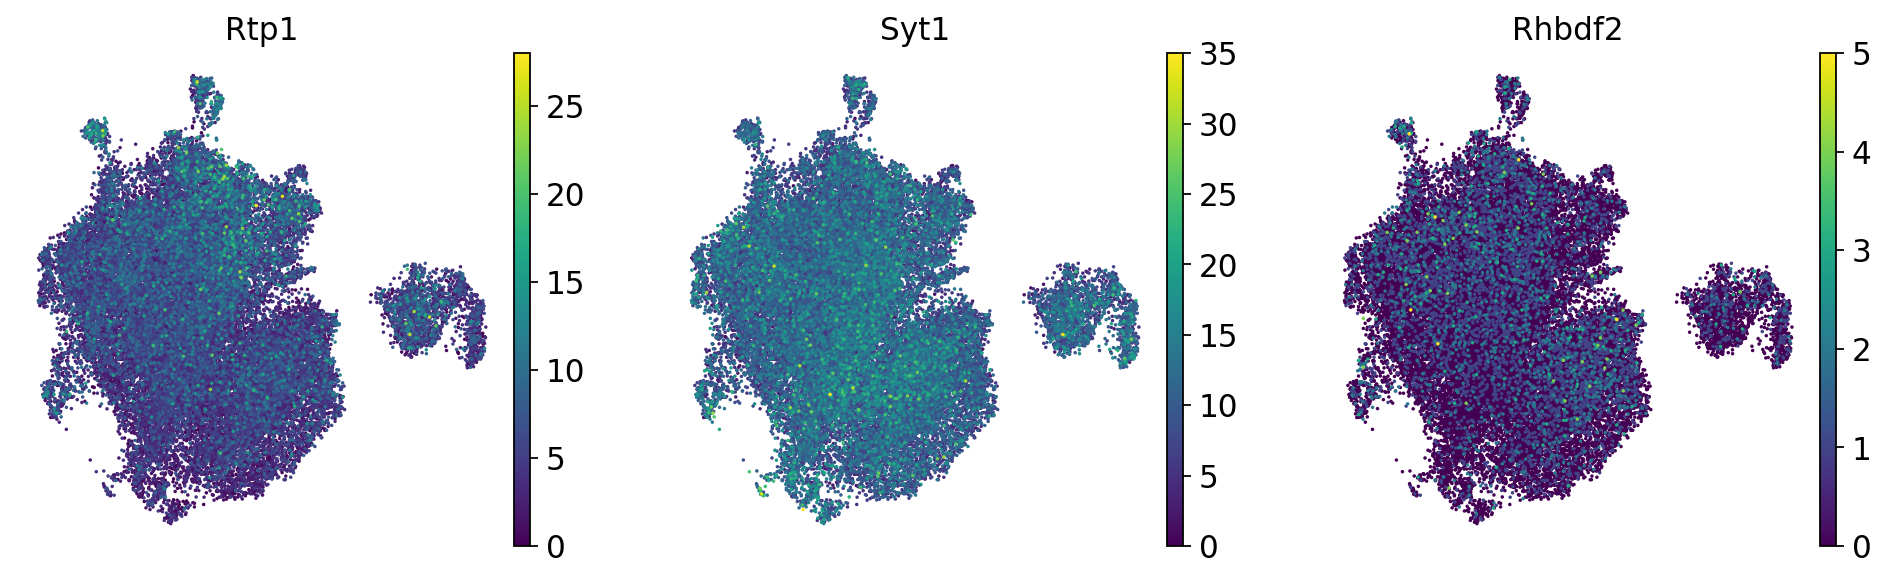

In [317]:
sc.set_figure_params(facecolor='white', color_map = 'viridis')
sc.pl.umap(adata, color=['Rtp1','Syt1', 'Rhbdf2'], 
           legend_loc='on data', size=10, 
           frameon=False)

#### Rhbdf2 analysis

In [ ]:
# Labels specific cells with Rhbdf2 counts more than 3 as a seperate cluster 
adata.obs.loc[adata.obs['Rhbdf2_counts'] < 1, 'Rhbdf2_cell' ] = "Rhbfd2_negative_cells"
adata.obs.loc[adata.obs['Rhbdf2_counts'] >= 1, 'Rhbdf2_cell' ] = "Rhbfd2_positive_cells"
# Labels specific OR expressin cells with different clusters
adata.obs.loc[adata.obs['Rhbdf2_sum'] < 1, 'Rhbdf2_Olfr' ] = "Rhbfd2_sum_Olfr < 1"
# adata.obs.loc[adata.obs['Rhbdf2_sum'] >= 10, 'Rhbdf2_Olfr' ] = "Rhbfd2_sum_Olfr < 20"
adata.obs.loc[adata.obs['Rhbdf2_sum'] >= 1, 'Rhbdf2_Olfr' ] = "Rhbfd2_sum_Olfr >= 1"

In [ ]:
sc.tl.rank_genes_groups(adata, 'Rhbdf2_cell', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names', 'pvals']}).to_csv('./Rhbdf2_byExpression.csv')

In [ ]:
sc.tl.rank_genes_groups(adata, 'Rhbdf2_Olfr', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names', 'pvals']}).to_csv('./Rhbdf2_byOlfr.csv')

Since S100A5 and Rhbdf2 seems to be negatively correlated with each other. Plot their expression counts for individual cells to visualize. 

In [ ]:
# Find the interested genes in contained in adata. 
# Additionally spits out the order in which the genes are stored in matrix 
interested_genes = ['Rhbdf2', 'S100a5', 'Lrrc3b', 'Kirrel2','Hbegf', 'Areg'
                   , 'Adam17', 'Tgfa', 'Epgn', 'Cx3cl1', 'Bcl2']
interested_genes = list(adata.raw.var_names[adata.raw.var_names.isin(interested_genes)])
count_df = pd.DataFrame(adata.raw.X[:, adata.raw.var_names.isin(interested_genes)], 
            columns=[i+"_counts" for i in interested_genes])
count_df.insert(0, 'Olfr', adata.obs['top_Olfr'].values)
# Save Rhbdf2 expression file 
count_df.to_csv('./output/Interested_gene_counts.csv')
count_df = pd.read_csv('./output/Interested_gene_counts.csv', index_col=0)

In [ ]:
# This line simply moves 'Rhbdf2' to the beginning of the list for plotting visual 
interested_genes.insert(0, interested_genes.pop(interested_genes.index('Rhbdf2')))

sc.set_figure_params(facecolor='white', color_map = 'viridis')
sc.pl.umap(adata, color=interested_genes,
           legend_loc='on data', size=30)

In [ ]:
fig = px.scatter(count_df, 
                 x = 'Rhbdf2_counts', 
                 y = 'S100a5_counts', 
                color='Olfr')
fig.show()
# fig.write_html('./output/Rhbdf2_S100a5_correlation.html')

Bins Rhbdf2 counts into box groups. 

In [ ]:
count_df['Rhbdf2_box_groups'] = count_df['Rhbdf2_counts'].apply(int).apply(str)
count_df.loc[count_df['Rhbdf2_box_groups'].str.contains("3|4|5"), 'Rhbdf2_box_groups'] = "3+"

count_df['Rhbdf2_present'] = count_df['Rhbdf2_counts'].apply(int).apply(str)
count_df.loc[count_df['Rhbdf2_present'].str.contains("1|2|3|4|5"), 'Rhbdf2_present'] = "1+"

In [ ]:
 # Quick plot to see how the other interested genes correslate with Rhbdf2
y_column = list(count_df.columns[count_df.columns.str.contains('_counts')].drop(['Rhbdf2_counts']))
plot_df = pd.melt(count_df, id_vars=['Olfr','Rhbdf2_present'], value_vars=y_column)

fig = px.box(plot_df, 
             x = 'variable', 
             y = 'value', 
             color = 'Rhbdf2_present',
             notched = True,
#              points='all',
             title = "Relative Expression of genes to presence of Rhbdf2"
            )
fig.update_layout(
        margin=dict(
            l=50, r=50, b=100, t=100,pad=10
        ),
        template='plotly_white'
    )
fig.show()
# fig.write_html('./output/plots/Rhbdf2_box.html')

In [ ]:
 # Quick plot to see how the other interested genes correslate with Rhbdf2
y_column = list(count_df.columns[count_df.columns.str.contains('_counts')].drop(['Rhbdf2_counts']))
plot_df = pd.melt(count_df, id_vars=['Olfr','Rhbdf2_box_groups'], value_vars=y_column)

fig = px.box(plot_df, 
             x = 'variable', 
             y = 'value', 
             color = 'Rhbdf2_box_groups',
             notched = True,
#              points='all',
             title = "Relative Expression of genes to Rhbdf2"
            )
fig.update_layout(
        margin=dict(
            l=50, r=50, b=100, t=100,pad=10
        ),
        template='plotly_white'
    )
fig.show()
fig.write_html('./output/plots/Rhbdf2_grouped_box.html')

Transforms count dataframe into log data frame and save. 

In [ ]:
# Log transform counts

log1p_df = pd.DataFrame(count_df[['Olfr', 'Rhbdf2_box_groups', 'Rhbdf2_present']])

for i in list(count_df.columns[count_df.columns.str.contains('_counts')].drop(['Rhbdf2_counts'])):
    log1p_df[i.split('_')[0]+'_log1p'] = np.log1p(count_df[i])
# Replace -inf values to 0
# count_df.loc[count_df['log(S100a5_counts)'] == -np.inf,'log(S100a5_counts)'] = 0

# Save count_df 
# log1p_df.to_csv('./Interested_gene_log1p.csv')

In [ ]:
 # Quick plot to see how the other interested genes correslate with Rhbdf2
y_column = list(log1p_df.columns[log1p_df.columns.str.contains('_log1p')])
plot_df = pd.melt(log1p_df, id_vars=['Olfr','Rhbdf2_present'], value_vars=y_column)

fig = px.box(plot_df, 
             x = 'variable', 
             y = 'value', 
             color = 'Rhbdf2_present',
             notched = True,
#              points='all',
             animation_group='variable',
#              boxmode='group',
             title = "log1p Expression of genes to presence of Rhbdf2"
            )
fig.update_layout(
        margin=dict(
            l=50, r=50, b=100, t=100,pad=10
        ),
        template='plotly_white'
    )
fig.show()
fig.write_html('./output/plots/Rhbdf2_log1p_box.html')

In [ ]:
for i in list(log1p_df.columns[log1p_df.columns.str.contains('_log1p')]):
    fig = px.box(log1p_df, 
                 x = 'Rhbdf2_box_groups', 
                 y = i, 
                 color = 'Rhbdf2_box_groups',
                 notched = True,
                 title = "log1p Expression of Rhbdf2 and " + i.split('_')[0]
                )
    fig = add_p_value_annotation(fig, [[0,1], [0,2], [0,3]])
#     fig = add_p_value_annotation(fig, [[0,1]])
    fig.update_layout(
        autosize=False,
        width=500,
        height=400,
        margin=dict(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=10
        ),
    #     paper_bgcolor='rgba(0,0,0,0)',
    #     plot_bgcolor='rgba(0,0,0,0)',
        template='plotly_white'
    )
    fig.show()
    fig.write_html('./output/plots/Individual_box/Rhbdf2_grouped_' + i.split('_')[0] + '.html')